In [159]:
import os
import glob
import sys
import numpy as np
import pandas as pd
sys.path.append('/cellar/users/aklie/opt/gene_program_evaluation')
sys.path.append('/cellar/users/aklie/opt/gene_program_evaluation/dashapp/')
import mudata
import scanpy as sc

from data_processing import count_unique

In [118]:
def count(categorical_var, count_var, dataframe):
    counts_df = dataframe.value_counts([categorical_var, count_var])
    counts_df = counts_df.groupby(categorical_var).sum()
    counts_df = counts_df.sort_values(ascending=False)
    counts_df = pd.DataFrame(counts_df.reset_index().values,
                             columns=[categorical_var, count_var])
    return counts_df

In [119]:
# Pipeline outputs
path_pipeline_outs = "/cellar/users/aklie/opt/gene_program_evaluation/dashapp/example_data/iPSC_EC_evaluations"

`path_pipeline_outs`, should be structured something like as follows:
    
```bash
path_pipeline_outs/
├── cNMF_60
├── cNMF_59
├── cNMF_58
...
├── cNMF_1
└── output.mdata
```

where `output.mdata` contains the MuData object with keys `input` that contains the original input matrix and `cNMF_60`, `cNMF_59`, ..., `cNMF_1` containing the cell and gene loadings for each of the inference runs.

The inference runs can be 1 of 4 types:
1. A single run of a method with a fixed number of components.
2. Cross k-analysis: where the number of components is varied across the same method.
3. Cross method analysis: where the number of components is fixed and the method is varied.
4. A combination of 2) and 3).

The keys of the MuData and the output subdirectories in `path_pipeline_outs` should be named accordingly to the desired type of analysis:
1. If one key is present, it can be named anything. In this scenario, the cross run analysis will be omitted.
2. A cross k-analysis should share the same base name and be suffixed by an integer that indicates the number of components used in inference. e.g. `cNMF_60`, `cNMF_59`, ..., `cNMF_1`.
3. A cross method analysis should have separate names for each method. e.g. `cNMF`, `Topyfic`, etc.
4. A combination of 2) and 3) should have the same base name for each method and be suffixed by an integer that indicates the number of components used in inference. e.g. `cNMF_60`, `cNMF_59`, ..., `cNMF_1`, `Topyfic_60`, `Topyfic_59`, ..., `Topyfic_1`.

# Load MuData

In [120]:
try:
    path_mdata = os.path.join(path_pipeline_outs, "cNMF_60_0.2_gene_names.h5mu")
    mdata = mudata.read_h5mu(path_mdata)
except:
    print("Could not load mdata")
    sys.exit(1)

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


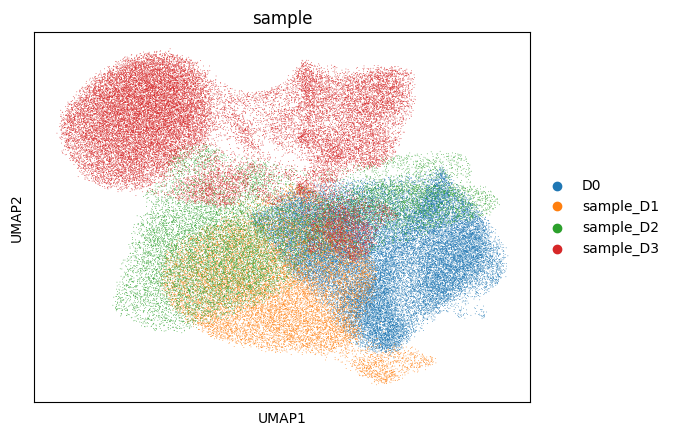

In [162]:
sc.pl.umap(mdata['rna'], color='sample')

# Get subdirectories

In [122]:
# Get all subdirectories of the pipeline outputs
subdirs = [x[0] for x in os.walk(path_pipeline_outs)][1:]
subdirs

['/cellar/users/aklie/opt/gene_program_evaluation/dashapp/example_data/iPSC_EC_evaluations/cNMF']

# Single run analysis
Here we will go through each subdirectory and corresponding key in the MuData object and extract per program metrics for plotting and evaluation.

## Explained variance

In [174]:
# For each subdirectory, find the file explained_variance_ratio.txt
# Read it in and
# Store this in a dictionary with the subdirectory dir_name as the key
explained_variance_ratios = {}
for subdir in subdirs:
    try:
        run_name = os.path.basename(subdir)
        df = pd.read_csv(os.path.join(subdir, "explained_variance_ratio.txt"), sep="\t")
        df.columns = ["program_name", "explained_variance_ratio"]
        explained_variance_ratios[run_name] = df
    except FileNotFoundError:
        print(f"File not found: {subdir}")

## Gene-set enrichment

In [175]:
# For each subdirectory, find the file geneset_enrichment.txt
# Store this dataframe in a dictionary with the key being the subdirectory name
gene_set_enrichment_dfs = {}
for subdir in subdirs:
    try:
        run_name = os.path.basename(subdir)
        gene_set_enrichment_file = os.path.join(subdir, "geneset_enrichment.txt")
        gene_set_enrichment_df = pd.read_csv(gene_set_enrichment_file, sep="\t")
        gene_set_enrichment_dfs[run_name] = gene_set_enrichment_df
    except FileNotFoundError:
        print(f"File not found: {gene_set_enrichment_file}")
        continue

In [176]:
categorical_var = "program_name"
count_var = "Term"
sig_var = "FDR q-val"
sig_threshold = 0.25

In [177]:
# Now for each df, calculate the number of unique gene sets that are enriched
# Include a FDR q-val cutoff
gene_sets_counts = {}
unique_gene_sets_counts = {}
for run_name, gene_set_enrichment_df in gene_set_enrichment_dfs.items():
    # Filter the dataframe based on the FDR q-value
    filtered_data = gene_set_enrichment_df[gene_set_enrichment_df[sig_var] < sig_threshold]

    # Get the count of all gene sets passing the FDR q-value cutoff for each program
    count_df = count(categorical_var=categorical_var, count_var=count_var, dataframe=filtered_data)
    gene_sets_counts[run_name] = count_df

    # Get the count of unique gene sets passing the FDR q-value cutoff for each program
    unique_data = filtered_data.sort_values(by=sig_var)
    unique_data = unique_data.drop_duplicates(subset=count_var)
    unique_df = count_unique(categorical_var=categorical_var, count_var=count_var, dataframe=unique_data)
    unique_gene_sets_counts[run_name] = unique_df

## Motif enrichment

In [178]:
# For each subdirectory, find the file motif_enrichment.txt
# Store this dataframe in a dictionary with the key being the subdirectory name
motif_enrichment_dfs = {}
for subdir in subdirs:
    try:
        run_name = os.path.basename(subdir)
        motif_enrichment_file = os.path.join(subdir, "motif_enrichment.txt")
        motif_enrichment_df = pd.read_csv(motif_enrichment_file, sep="\t")
        motif_enrichment_dfs[run_name] = motif_enrichment_df
    except FileNotFoundError:
        print(f"File not found: {motif_enrichment_file}")
        continue

## Trait enrichment

In [180]:
# For each subdirectory, find the file trait_enrichment.txt
# Store this dataframe in a dictionary with the key being the subdirectory name
trait_enrichment_dfs = {}
for subdir in subdirs:
    try:
        run_name = os.path.basename(subdir)
        trait_enrichment_file = os.path.join(subdir, "trait_enrichment.txt")
        trait_enrichment_df = pd.read_csv(trait_enrichment_file, sep="\t")
        trait_enrichment_dfs[run_name] = trait_enrichment_df
    except FileNotFoundError:
        print(f"File not found: {trait_enrichment_file}")
        continue

# Cross run analysis

## Cumulative explained variance

In [128]:
# For each subdirectory, find the file explained_variance_ratio.txt
# Read it in and sum across all the programs to get one value
# Store this in a dictionary with the subdirectory dir_name as the key
cumulative_explained_variance_ratios = {}
for subdir in subdirs:
    try:
        run_name = os.path.basename(subdir)
        df = pd.read_csv(os.path.join(subdir, "explained_variance_ratio.txt"), sep="\t")
        cumulative_explained_variance_ratios[run_name] = df["explained_variance_ratio_X"].sum()
    except FileNotFoundError:
        print(f"File not found: {subdir}")

In [129]:
cumulative_explained_variance_ratios

{'cNMF': -3.7118508404785633}

## Reconstruction error

In [142]:
mdata.mod

{'rna': AnnData object with n_obs × n_vars = 92284 × 5451
     obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'leiden', 'n_counts'
     obsm: 'X_pca', 'X_umap'
     layers: 'norm10k',
 'cNMF': AnnData object with n_obs × n_vars = 92284 × 60
     obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'leiden', 'n_counts'
     uns: 'guide_names', 'guide_targets', 'var_names'
     obsm: 'guide_assignment'
     varm: 'loadings'}

In [157]:
# For each non "rna" key in the mdata, we want to reconstruct the gene expression matrix
# We will multiply the program loadings in varm (program x gene) by the cell loadings in .X (cell x program) to do this
# This will give us a cell x gene matrix that we will then take the sum of sum of squares of the element-wise difference with the rna.X

# Get the proper rna.X
orig_mtx = mdata["rna"].layers["norm10k"].copy().toarray()

# Calculate a reconstructed matrix for each non-rna key in mdata
errors = {}
for key in mdata.mod.keys():
    if key == "rna":
        continue
    program_mtx = mdata[key].varm["loadings"]
    cell_mtx = mdata[key].X
    reconstructed_mtx = np.dot(cell_mtx, program_mtx)
    error = np.sum((orig_mtx - reconstructed_mtx) ** 2)
    errors[key] = error

In [153]:
reconstructed_mtx.shape

(92284, 5451)

In [155]:
orig_mtx.shape

(92284, 5451)

In [158]:
errors

{'cNMF': 436202896.33146477}

# DONE!

---

In [ ]:
def count_unique(categorical_var, count_var, dataframe, cummul=False, unique=False):
    counts_df = count(categorical_var, count_var, dataframe)
    new_df = []
    terms = []
    # AK: the order of programs is based on the number of unique terms, not on the most significant terms
    for prog in counts_df[categorical_var].unique():
        terms_ = dataframe.loc[dataframe[categorical_var] == prog, count_var].unique()
        unique_terms = [term for term in terms_ if term not in terms]
        terms.extend(unique_terms)
        new_df.append([prog, len(unique_terms)])
    new_df = pd.DataFrame(new_df, columns=[categorical_var, count_var])
    if cummul:
        new_df[count_var] = new_df[count_var].cumsum()
    if unique:
        return new_df
    else:
        return counts_df

In [ ]:
# A term that is shared across multiple programs will be counted once for each program it is associated with
counts_df = dataframe.value_counts([categorical_var, count_var])
counts_df = counts_df.groupby(categorical_var).sum()
counts_df = counts_df.sort_values(ascending=False)
counts_df = pd.DataFrame(counts_df.reset_index().values,
                             columns=[categorical_var, count_var])
counts_df

,program_name,Term
0,4,182
1,6,132
2,20,119
3,0,97
4,10,45
5,7,34
6,8,14
7,12,14
8,16,12
9,2,9


In [169]:
count_unique(categorical_var, count_var, filtered_data, cummul=False, unique=False)["Term"].sum()

291

In [ ]:
# A program that has multiple terms that are shared across multiple programs will only be counted in its most significant program

# Start by sorting the dataframe by the FDR q-value and removing duplicates in the Term column


# Now count the number of unique terms for each program
counts_df = count(categorical_var, count_var, dataframe)
counts_df

,program_name,Term
0,4,93
1,6,58
2,0,49
3,20,31
4,7,12
5,47,6
6,10,6
7,12,5
8,24,4
9,14,3


In [ ]:
new_df = []
terms = []
for prog in counts_df[categorical_var].unique():
    terms_ = dataframe.loc[dataframe[categorical_var] == prog, count_var].unique()
    unique_terms = [term for term in terms_ if term not in terms]
    terms.extend(unique_terms)
    new_df.append([prog, len(unique_terms)])
new_df = pd.DataFrame(new_df, columns=[categorical_var, count_var]).sort_values(count_var, ascending=False)
new_df

,program_name,Term
0,4,182
3,0,45
1,6,28
2,20,8
10,47,5
6,8,4
4,10,3
17,14,3
5,7,2
12,35,2
